# Septin Analysis: comparing the mean shape of each group

$\textbf{Lead Author:}$ Adele Myers

# 1. Overview of analysis

We calculate the mean shape of 1) Control Cells 2) Septin Overexpression Cells 3) Septin Knockdown Cells. Then we show how far each point lies from the mean shape

# 2. Imports

## 2.1 Notebook setup

In [249]:
import os
import subprocess
os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)
os.chdir(geomstats_gitroot_path[:-1])
print("Working directory: ", os.getcwd())

import warnings
warnings.filterwarnings("ignore")

Working directory:  /Users/adelemyers/code/dyn


## 2.2 Standard Imports

In [250]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [251]:
from geomstats.learning.pca import TangentPCA

from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn import manifold
from joblib import Parallel, delayed
from numba import jit, njit, prange

## 2.3 Project-specific imports

In [252]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, ClosedDiscreteCurves

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.kmeans import RiemannianKMeans
from geomstats.learning.mdm import RiemannianMinimumDistanceToMeanClassifier
from geomstats.learning.pca import TangentPCA

import dyn.dyn.datasets.experimental as experimental
import dyn.dyn.features.basic as basic
import dyn.dyn.viz as viz

viz.init_matplotlib()
%config InlineBackend.figure_formats = ['svg']

# 3. Setup

## 3.1 Load the datasets of interest

In [294]:
import dyn.dyn.datasets.experimental as experimental

#this forces the notebook to re-load
import importlib
importlib.reload(experimental)


control_centers, control_shapes, control_imgs, control_label, control_theta_array, control_circle_coords_array, control_lefts_array, control_group_tifs = experimental.load_septin_cells( 'control',
    n_sampling_points=100)

knockdown_centers, knockdown_shapes, knockdown_imgs, knockdown_label, knockdown_theta_array, knockdown_circle_coords_array, knockdown_lefts_array, knockdown_group_tifs = experimental.load_septin_cells( 'septin_knockdown',
    n_sampling_points=100)

overexp_centers, overexp_shapes, overexp_imgs, overexp_label, overexp_theta_array, overexp_circle_coords_array, overexp_lefts_array, overexp_group_tifs = experimental.load_septin_cells( 'septin_overexpression',
    n_sampling_points=100)

Loading control data
n_sampling_points= 100
(36, 512, 512)
[415.5 118.5]
[415.5 118.5]
[453.5 182.5]
[453.5 182.5]
[ 76.5 365.5]
[ 76.5 365.5]
[229.5  87.5]
[229.5  87.5]
[228.5 371.5]
[228.5 371.5]
[444.5  87.5]
[444.5  87.5]
[ 68.5 407.5]
[ 68.5 407.5]
[238.5 398.5]
[238.5 398.5]
[173.5  84.5]
[173.5  84.5]
[246.5  46.5]
[246.5  46.5]
[339.5 106.5]
[339.5 106.5]
[128.5 441.5]
[128.5 441.5]
[275.5 446.5]
[275.5 446.5]
[ 52.5 239.5]
[ 52.5 239.5]
[423.5 158.5]
[423.5 158.5]
[196.5  97.5]
[196.5  97.5]
[209.5 449.5]
[209.5 449.5]
[422.5 341.5]
[422.5 341.5]
[ 67.5 398.5]
[ 67.5 398.5]
[453.5 312.5]
[453.5 312.5]
[119.5 174.5]
[119.5 174.5]
[210.5  79.5]
[210.5  79.5]
[380.5 223.5]
[380.5 223.5]
[382.5 403.5]
[382.5 403.5]
[264.5  87.5]
[264.5  87.5]
[368.5 123.5]
[368.5 123.5]
[403.5 392.5]
[403.5 392.5]
[123.5 330.5]
[123.5 330.5]
[306.5  65.5]
[306.5  65.5]
[280.5 444.5]
[280.5 444.5]
[ 66.5 159.5]
[ 66.5 159.5]
[355.5 112.5]
[355.5 112.5]
[166.5 443.5]
[166.5 443.5]
[111.5 214.5]
[11

In [295]:
print(control_shapes.shape)

torch.Size([36, 100, 2])


In [296]:
#saving shapes in text files

reshaped_control_shapes = control_shapes.reshape(control_shapes.shape[0], -1)
print(reshaped_control_shapes)
reshaped_knockdown_shapes = knockdown_shapes.reshape(knockdown_shapes.shape[0], -1)
reshaped_overexp_shapes = overexp_shapes.reshape(overexp_shapes.shape[0], -1)


np.savetxt("control_shapes.txt", reshaped_control_shapes, delimiter =", ")
np.savetxt("knockdown_shapes.txt", reshaped_knockdown_shapes, delimiter =", ")
np.savetxt("overexp_shapes.txt", reshaped_overexp_shapes, delimiter =", ")

tensor([[-137.3365,  -36.3556, -127.6462,  ...,  -18.2959, -143.2679,
          -28.4609],
        [-158.0212,  -39.3604, -149.9586,  ...,  -22.8040, -159.6557,
          -30.8235],
        [ 158.3113,   62.9045,  152.6732,  ...,   47.4991,  157.9990,
           54.8633],
        ...,
        [ 141.4542,   17.7838,  141.9281,  ...,    8.7783,  137.7721,
           11.7318],
        [-141.6253,  -32.7379, -132.9015,  ...,  -15.9120, -143.2817,
          -25.2041],
        [  -6.4360,  -95.6556,    1.4428,  ...,  -92.5976,  -15.2995,
          -92.8525]])


In [297]:
# reshaped_control_shapes = control_shapes.reshape(control_shapes.shape[0], -1)
# print(reshaped_control_shapes)
# reshaped_knockdown_shapes = knockdown_shapes.reshape(knockdown_shapes.shape[0], -1)
# reshaped_overexp_shapes = overexp_shapes.reshape(overexp_shapes.shape[0], -1)


np.savetxt("control_theta_array.txt", control_theta_array, delimiter =", ")
np.savetxt("knockdown_theta_array.txt", knockdown_theta_array, delimiter =", ")
np.savetxt("overexp_theta_array.txt", overexp_theta_array, delimiter =", ")

## 3.2 Define Shape Spaces

In [298]:
R1 = Euclidean(dim=1)
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2)
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric
L2_METRIC = CURVES_SPACE.l2_curves_metric

ELASTIC_METRIC = {}
AS = [0.75, 0.5, 0.25, 0.01]
BS = [0.5, 0.5, 0.5, 0.5]
for a, b in zip(AS, BS):
    ELASTIC_METRIC[a, b] = DiscreteCurves(R2, a=a, b=b).elastic_metric
    
    
METRICS = {}
METRICS["Linear"] = L2_METRIC
METRICS["SRV"] = SRV_METRIC

# 4. Sample Means

## 4.1 Control Means

We compare results when computing the mean cell versus the mean cell shapes with different elastic metrics.

In [299]:
control_means = {}

control_means["Linear"] = gs.mean(control_shapes, axis=0)
np.savetxt("control_mean.txt", control_means["Linear"], delimiter =", ")

control_means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        #point_type="matrix", 
        method="default").fit(control_shapes).estimate_
for a, b in zip(AS, BS):
    control_means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
            #point_type="matrix", 
            method="default").fit(control_shapes).estimate_

Now, we plot the cell shapes corresponding to the means with different metrics.

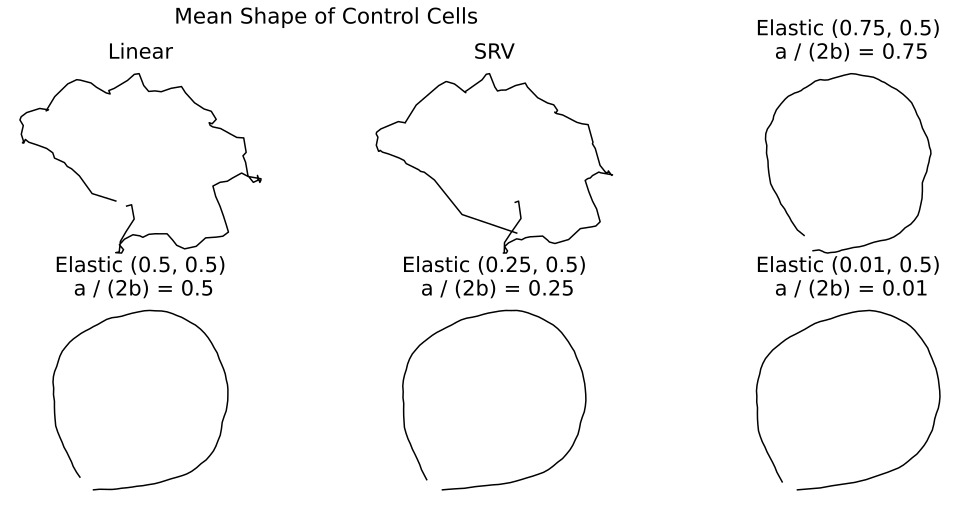

In [300]:
fig = plt.figure(figsize=(18, 8))

#plt.figtext(0.5, 1, 'Effect of bias addition', ha='right')

fig. suptitle("Mean Shape of Control Cells", ha='right')

ncols = len(control_means) // 2

for i, (mean_name, mean) in enumerate(control_means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)

### IMPORTANT: 
now, we project these "open curve" shape onto the shape space manifold of closed curves. This does not change the mean shape information at all. Its only purpose is to give us the "closed curve" version of our previous results. We wish to do this because cells contours are closed curves, and thus it would be better for our results to also be closed curves. 

AssertionError: The square root velocity framework is only defined for discrete curves with distinct consecutive sample points.

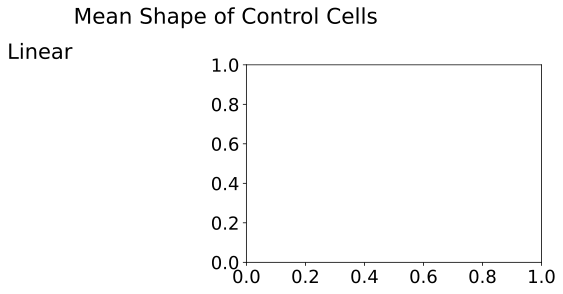

In [22]:
fig = plt.figure(figsize=(18, 8))

fig. suptitle("Mean Shape of Control Cells", ha='right')

ncols = len(control_means) // 2

for i, (mean_name, mean) in enumerate(control_means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    mean = CLOSED_CURVES_SPACE.projection(mean)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)
plt.savefig("dyn/saved_figs/Control_Means.png")

## 4.2 Septin Knockdown Means

In [301]:
knockdown_means = {}

knockdown_means["Linear"] = gs.mean(knockdown_shapes, axis=0)
np.savetxt("knockdown_mean.txt", knockdown_means["Linear"], delimiter =", ")

knockdown_means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        #point_type="matrix", 
        method="default").fit(knockdown_shapes).estimate_
for a, b in zip(AS, BS):
    knockdown_means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
            #point_type="matrix", 
            method="default").fit(knockdown_shapes).estimate_

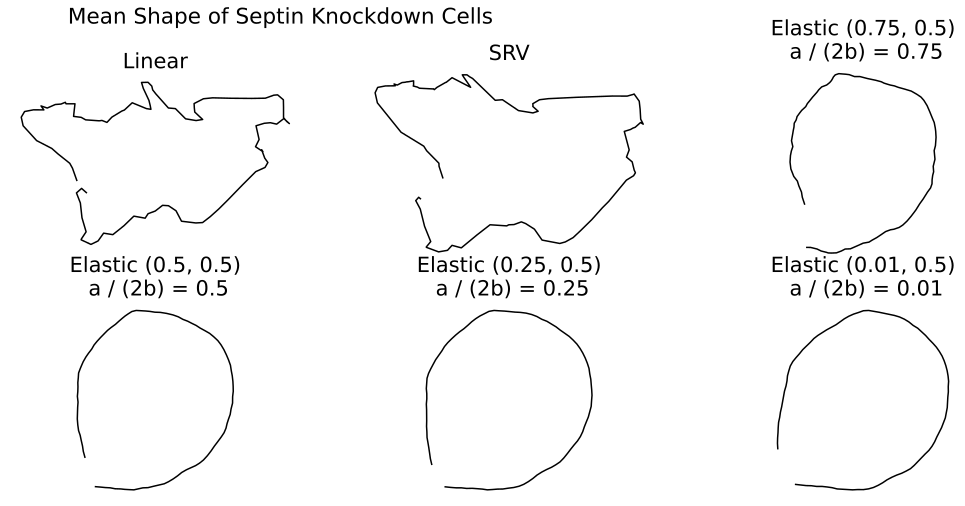

In [302]:
fig = plt.figure(figsize=(18, 8))

fig. suptitle("Mean Shape of Septin Knockdown Cells", ha='right')

ncols = len(knockdown_means) // 2

for i, (mean_name, mean) in enumerate(knockdown_means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)

Again, we project the "open curve" results to the space of "closed curves" to get our final result:

KeyboardInterrupt: 

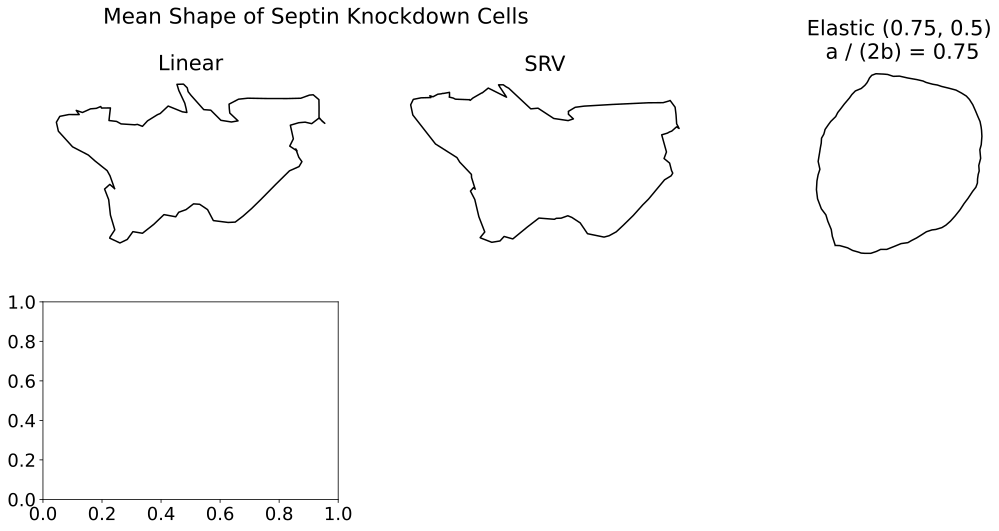

In [260]:
fig = plt.figure(figsize=(18, 8))

fig. suptitle("Mean Shape of Septin Knockdown Cells", ha='right')

ncols = len(knockdown_means) // 2

for i, (mean_name, mean) in enumerate(knockdown_means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    mean = CLOSED_CURVES_SPACE.projection(mean)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)
plt.savefig("dyn/saved_figs/Knockdown_Means.png")

## 4.2 Septin Overexpression Means

In [303]:
overexp_means = {}

overexp_means["Linear"] = gs.mean(overexp_shapes, axis=0)
np.savetxt("overexp_mean.txt", overexp_means["Linear"], delimiter =", ")

overexp_means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        #point_type="matrix", 
        method="default").fit(overexp_shapes).estimate_
for a, b in zip(AS, BS):
    overexp_means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
            #point_type="matrix", 
            method="default").fit(overexp_shapes).estimate_

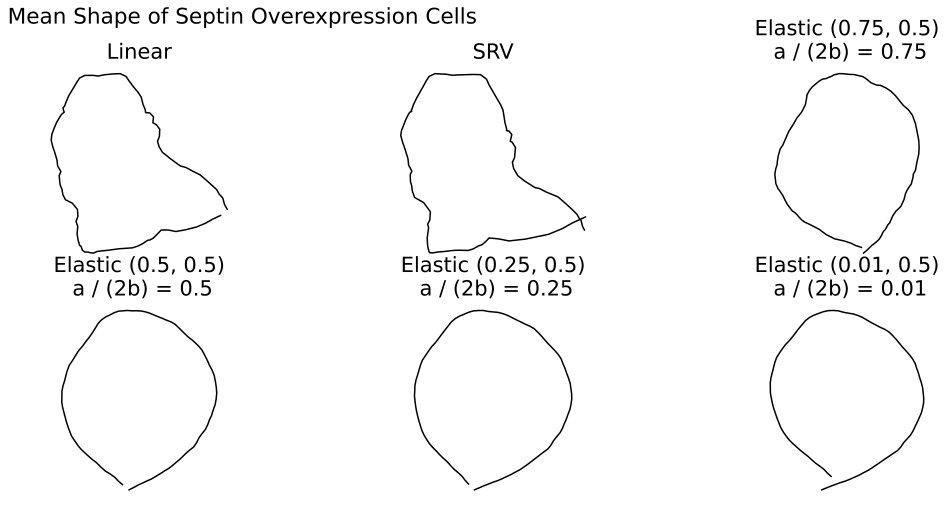

In [304]:
fig = plt.figure(figsize=(18, 8))

fig. suptitle("Mean Shape of Septin Overexpression Cells", ha='right')

ncols = len(overexp_means) // 2

for i, (mean_name, mean) in enumerate(overexp_means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)

Once again, we project our "open space" curves to the space of "closed curves" to get our final result:

In [ ]:
fig = plt.figure(figsize=(18, 8))

fig. suptitle("Mean Shape of Septin Overexpression Cells", ha='right')

ncols = len(overexp_means) // 2

for i, (mean_name, mean) in enumerate(overexp_means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    mean = CLOSED_CURVES_SPACE.projection(mean)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)
plt.savefig("dyn/saved_figs/Overexpression_Means.png")

# 5. Analysis

- We see that the Control means are narrower ellipses with a small protrusion. 
- We see that the Septin Knockdown means shows a large protrusion. This reflects that on average, the septin knockdown cells have very large protrusions (potentially because septins are required for detachment, and the protrusions in this dataset are not detatching).
- We see that the Septin Overexpression means are wider ellipses with no obvious protrusion (potentially because septins are doing a VERY good job of detatching the protrusions so that there are not as many large protrusions in the dataset?).

-----
# Misc. Analyses:
-----

# 6. How far is each data point from the mean shape?

In this section, we compute how far each shape is from the mean (the distance between each shape and the mean). Then, we summarize this information in a histogram. these histograms show the distribution of datapoints' distances from the 'Linear' mean and the 'SRV metric' mean. 

In [305]:
n_sampling_points=300
label_name = 'treatment'

## 5.1 Distances to control mean

In [306]:
control_dists = {}

# aaa = gs.linalg.norm(control_means["Linear"] - control_shapes[0], axis=-1)
# print(aaa.shape)
# print(max(aaa))
# HACK ALERT: We compute the Haussdorf distance under the Linear label
control_dists["Linear"] = [
    max(gs.linalg.norm(control_means["Linear"] - shape, axis=-1)).numpy() / n_sampling_points for shape in control_shapes]

control_dists["SRV"] = [
    SRV_METRIC.dist(control_means["SRV"], shape).numpy() / n_sampling_points for shape in control_shapes
]

for a, b in zip(AS, BS):
    control_dists[a, b] =  [
    ELASTIC_METRIC[a, b].dist(control_means[a, b], shape).numpy() / n_sampling_points for shape in control_shapes
]

In [307]:
control_dists_summary = pd.DataFrame(
    data={
        label_name: control_label,
        "Linear": control_dists["Linear"],
        "SRV": control_dists["SRV"],
    }
)

for a, b in zip(AS, BS):
    control_dists_summary[f"Elastic({a}, {b})"] = control_dists[a, b]
    
control_dists_summary.head()

,treatment,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,control,0.599439,0.104277,0.089703,0.064547,0.034894,0.014104
1,control,0.536630,0.093423,0.075718,0.050294,0.024316,0.006543
2,control,0.580802,0.101574,0.110912,0.100121,0.060515,0.006684
3,control,0.496131,0.088306,0.070738,0.046095,0.021947,0.007659
4,control,0.519983,0.101784,0.109327,0.097146,0.058384,0.009129


In [308]:
print(len(control_dists_summary))

36


Now, we generate histograms showing how far points in the dataset are from the mean (for the linear and SRV metrics)

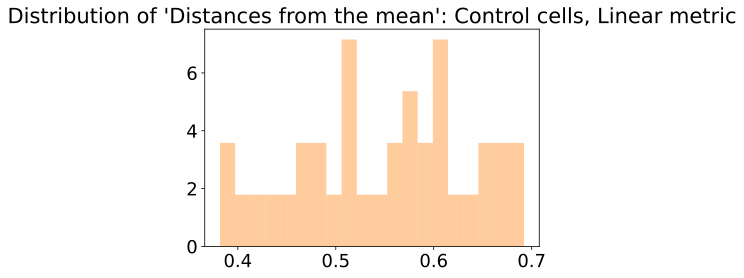

In [309]:
ds = control_dists_summary['Linear']
plt.hist(
            ds, bins=20, alpha=0.4, density=True, label='control', color=f"C{1}"
        )
plt.title("Distribution of 'Distances from the mean': Control cells, Linear metric")
plt.savefig("dyn/saved_figs/dist_control_linear.png")

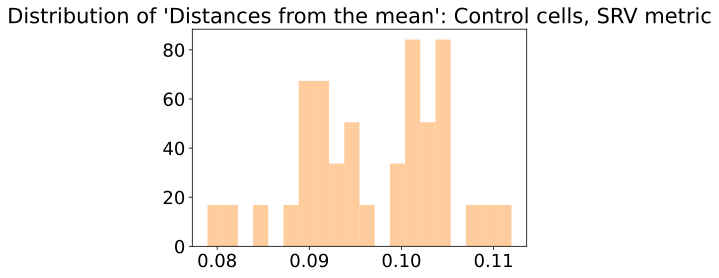

In [310]:
ds = control_dists_summary['SRV']
plt.hist(
            ds, bins=20, alpha=0.4, density=True, label='control', color=f"C{1}"
        )

plt.title("Distribution of 'Distances from the mean': Control cells, SRV metric")
plt.savefig("dyn/saved_figs/dist_control_SRV.png")

## 5.2 Distances from Septin Knockdown mean: Edit: distance from Knockdown cells to control mean

In [311]:
knockdown_dists = {}

knockdown_dists["Linear"] = [max(gs.linalg.norm(control_means["Linear"] - shape, axis=-1)).numpy() / n_sampling_points for shape in knockdown_shapes]

knockdown_dists["SRV"] = [
    SRV_METRIC.dist(knockdown_means["SRV"], shape).numpy() / n_sampling_points for shape in knockdown_shapes
]

for a, b in zip(AS, BS):
    knockdown_dists[a, b] =  [
    ELASTIC_METRIC[a, b].dist(knockdown_means[a, b], shape).numpy() / n_sampling_points for shape in knockdown_shapes
]

In [312]:
knockdown_dists_summary = pd.DataFrame(
    data={
        label_name: knockdown_label,
        "Linear": knockdown_dists["Linear"],
        "SRV": knockdown_dists["SRV"],
    }
)

for a, b in zip(AS, BS):
    knockdown_dists_summary[f"Elastic({a}, {b})"] = knockdown_dists[a, b]
    
knockdown_dists_summary.head()

,treatment,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,septin_knockdown,0.542025,0.106376,0.102499,0.084978,0.049406,0.007456
1,septin_knockdown,0.896684,0.111379,0.098233,0.070981,0.037262,0.012302
2,septin_knockdown,0.716040,0.114727,0.099573,0.074130,0.040792,0.013139
3,septin_knockdown,0.654913,0.117715,0.101688,0.074903,0.041584,0.017434
4,septin_knockdown,0.512277,0.097702,0.098403,0.081299,0.046700,0.011034


Again, now we generate histograms that show the distribution of datapoints' distances from the Septin Knockdown mean

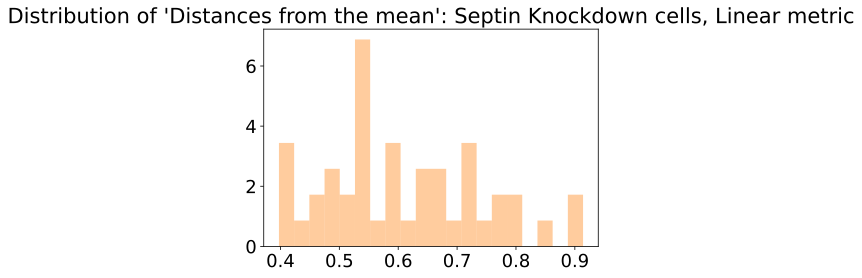

In [313]:
ds = knockdown_dists_summary['Linear']
plt.hist(
            ds, bins=20, alpha=0.4, density=True, label='control', color=f"C{1}"
        )
plt.title("Distribution of 'Distances from the mean': Septin Knockdown cells, Linear metric")
plt.savefig("dyn/saved_figs/dist_knockdown_linear.png")

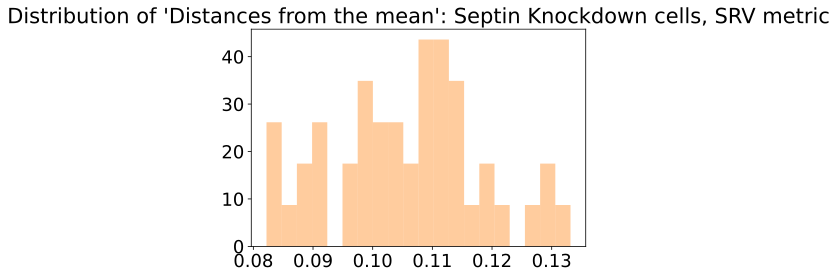

In [314]:
ds = knockdown_dists_summary['SRV']
plt.hist(
            ds, bins=20, alpha=0.4, density=True, label='control', color=f"C{1}"
        )
plt.title("Distribution of 'Distances from the mean': Septin Knockdown cells, SRV metric")
plt.savefig("dyn/saved_figs/dist_knockdown_SRV.png")

## 5.3 Distances for Septin Overexpression mean: Edit: distance from Overexpression cells to control mean

In [315]:
overexp_dists = {}

overexp_dists["Linear"] = [max(gs.linalg.norm(control_means["Linear"] - shape, axis=-1)).numpy() / n_sampling_points for shape in overexp_shapes]

overexp_dists["SRV"] = [
    SRV_METRIC.dist(overexp_means["SRV"], shape).numpy() / n_sampling_points for shape in overexp_shapes
]

for a, b in zip(AS, BS):
    overexp_dists[a, b] =  [
    ELASTIC_METRIC[a, b].dist(overexp_means[a, b], shape).numpy() / n_sampling_points for shape in overexp_shapes
]

In [316]:
overexp_dists_summary = pd.DataFrame(
    data={
        label_name: overexp_label,
        "Linear": overexp_dists["Linear"],
        "SRV": overexp_dists["SRV"],
    }
)

for a, b in zip(AS, BS):
    overexp_dists_summary[f"Elastic({a}, {b})"] = overexp_dists[a, b]
    
overexp_dists_summary.head()

,treatment,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,septin_overexpression,0.453052,0.103942,0.093563,0.070471,0.038437,0.010133
1,septin_overexpression,0.725912,0.114729,0.130261,0.118848,0.072182,0.010939
2,septin_overexpression,0.580687,0.092766,0.076174,0.051053,0.024576,0.005519
3,septin_overexpression,0.547913,0.100535,0.123935,0.119126,0.074118,0.008084
4,septin_overexpression,0.498027,0.100109,0.075369,0.044527,0.017992,0.005504


Again, now we generate histograms that show the distribution of datapoints' distances from the Septin Knockdown mean

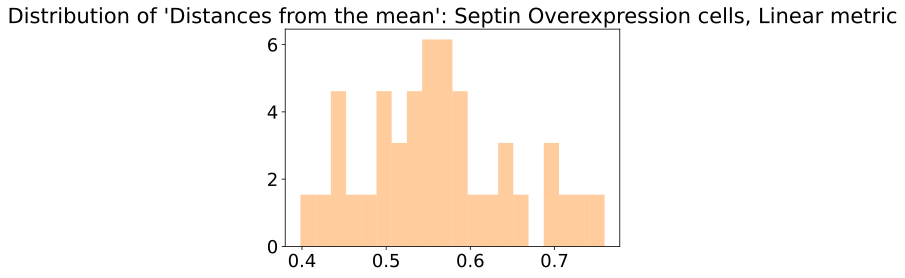

In [317]:
ds = overexp_dists_summary['Linear']
plt.hist(
            ds, bins=20, alpha=0.4, density=True, label='control', color=f"C{1}"
        )

plt.title("Distribution of 'Distances from the mean': Septin Overexpression cells, Linear metric")
plt.savefig("dyn/saved_figs/dist_overexp_linear.png")

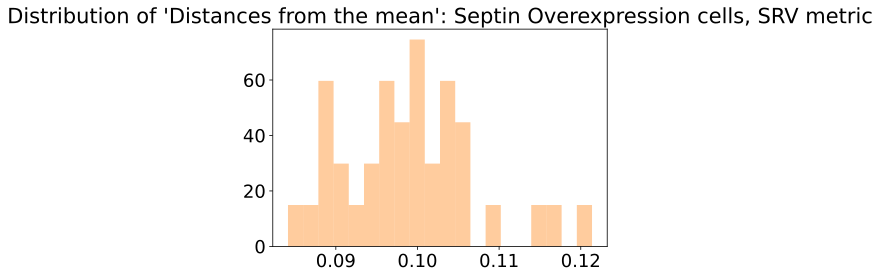

In [318]:
ds = overexp_dists_summary['SRV']
plt.hist(
            ds, bins=20, alpha=0.4, density=True, label='control', color=f"C{1}"
        )
plt.title("Distribution of 'Distances from the mean': Septin Overexpression cells, SRV metric")
plt.savefig("dyn/saved_figs/dist_overexp_SRV.png")

## KS-test comparing statistical distributions

At significance level alpha = 0.05, we need p-values lower than 0.05 / 3 = 0.0166 for any of the 3 hypothesis tests to be considered significant. (Bonferroni correction for multiple hypothesis tests).

Here, the tests being significant means that the two distributions tested are considered to be statistically significantly different, at significance level alpha.

In [319]:
sample1 = overexp_dists["Linear"]
sample2 = control_dists["Linear"]
print(stats.kstest(sample1, sample2))

sample1 = overexp_dists["Linear"]
sample2 = knockdown_dists["Linear"]
print(stats.kstest(sample1, sample2))

sample1 = control_dists["Linear"]
sample2 = knockdown_dists["Linear"]
print(stats.kstest(sample1, sample2))

KstestResult(statistic=0.1388888888888889, pvalue=0.8848803300554184)
KstestResult(statistic=0.23333333333333334, pvalue=0.19542337876999477)
KstestResult(statistic=0.2722222222222222, pvalue=0.08603538803475387)


In [320]:
sample1 = overexp_dists["SRV"]
sample2 = control_dists["SRV"]
print(stats.kstest(sample1, sample2))

sample1 = overexp_dists["SRV"]
sample2 = knockdown_dists["SRV"]
print(stats.kstest(sample1, sample2))

sample1 = control_dists["SRV"]
sample2 = knockdown_dists["SRV"]
print(stats.kstest(sample1, sample2))

KstestResult(statistic=0.19444444444444445, pvalue=0.5100108838989977)
KstestResult(statistic=0.4222222222222222, pvalue=0.0010502121859427263)
KstestResult(statistic=0.45, pvalue=0.00036932872588470373)


## 5.4 Graph with all three

In [321]:
total_dists_summary= [control_dists_summary,knockdown_dists_summary,overexp_dists_summary]

# print(total_dists_summary[0].shape)
# print(total_dists_summary[1].shape)
# print(total_dists_summary[2]["Linear"])

In [322]:
xx_1 = {}

for i_metric, metric_name in enumerate(["Linear", "SRV"]):
    min_control = min(total_dists_summary[0][metric_name])
    min_knockdown = min(total_dists_summary[1][metric_name])
    min_overexpression = min(total_dists_summary[2][metric_name])
    
    max_control = max(total_dists_summary[0][metric_name])
    max_knockdown = max(total_dists_summary[1][metric_name])
    max_overexpression = max(total_dists_summary[2][metric_name])
    
    min_dists = np.array(min(min_control,min_knockdown,min_overexpression))
    max_dists =np.array(max(max_control,max_knockdown,max_overexpression))
    xx_1[i_metric] = np.linspace(min_dists, max_dists, 100)
    
xx_2 = {}
for i_metric, (a, b) in enumerate(zip(AS, BS)):
    min_control = min(total_dists_summary[0][f"Elastic({a}, {b})"])
    min_knockdown = min(total_dists_summary[1][f"Elastic({a}, {b})"])
    min_overexpression = min(total_dists_summary[2][f"Elastic({a}, {b})"])
    
    max_control = max(total_dists_summary[0][f"Elastic({a}, {b})"])
    max_knockdown = max(total_dists_summary[1][f"Elastic({a}, {b})"])
    max_overexpression = max(total_dists_summary[2][f"Elastic({a}, {b})"])
    
    min_dists = np.array(min(min_control,min_knockdown,min_overexpression))
    max_dists =np.array(max(max_control,max_knockdown,max_overexpression))
    xx_2[i_metric] = np.linspace(min_dists, max_dists, 100)


In [323]:
def hist_dists_to_means(total_dists_summary, label_color_incr):
    #fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    
    
#     for i_metric, dist_name in enumerate(['Linear', 'SRV']):
#         for i_group, group in enumerate(total_dists_summary):
#             ds = total_dists_summary[i_group][dist_name]
#             axs[i_metric].hist(
#                 ds, bins=20, alpha=0.4, density=True, label=total_dists_summary[i_group]['treatment'][0], 
#                 color=f"C{i_group+label_color_incr}"
#                 )
#             kde = stats.gaussian_kde(ds)
#             print(kde)
#             axs[i_metric].plot(xx_1[i_metric], kde(xx_1[i_metric]), color=f"C{i_group+label_color_incr}")
#         axs[i_metric].legend(prop={'size': 14})
#         axs[i_metric].tick_params(axis="x", labelsize=15)
#         axs[i_metric].set_title(f"Distances to\n {dist_name} mean\n colored by group\n ")
#     plt.tight_layout()
#     plt.savefig("dyn/saved_figs/comprehensive_hist1.png") 
        
    plt.figure(figsize=(10,7))
        
    #for i_metric, dist_name in enumerate(['Linear', 'SRV']):
    for i_group, group in enumerate(total_dists_summary):
        ds = total_dists_summary[i_group]['Linear']
        plt.hist(
            ds, bins=12, 
            alpha=0.2, density=True, #we need density = true becuase if we take it out then the bars are too small to be 
            #seen on the scale of the plot. we need them to be on the same scale
            label=total_dists_summary[i_group]['treatment'][0], 
            color=f"C{i_group+label_color_incr}"
            )
        kde = stats.gaussian_kde(ds)
        print(kde)
        plt.plot(xx_1[0], kde(xx_1[0]), color=f"C{i_group+label_color_incr}")
    plt.legend(prop={'size': 14})
    plt.tick_params(axis="x", labelsize=15)
    plt.title(f"Distances to\n Linear mean\n colored by group\n ")
        
    plt.tight_layout()
    plt.savefig("dyn/saved_figs/linear_distances_hist.svg") 
    plt.savefig("dyn/saved_figs/linear_distances_hist.png") 
            
    #fig, axs = plt.subplots(1, len(AS), figsize=(15, 2), #sharey=True
                          # )
    
#     for i_metric, (a, b) in enumerate(zip(AS, BS)):
#         for i_group, group in enumerate(total_dists_summary):
#             ds = total_dists_summary[i_group][f"Elastic({a}, {b})"]
#             axs[i_metric].hist(
#                 ds, bins=20, alpha=0.4, density=True, label=total_dists_summary[i_group]['treatment'][0], 
#                 color=f"C{i_group+label_color_incr}"
#                 )
#             kde = stats.gaussian_kde(ds)
#             axs[i_metric].plot(xx_2[i_metric], kde(xx_2[i_metric]), color=f"C{i_group+label_color_incr}")
#         axs[i_metric].legend(prop={'size': 6})
#         axs[i_metric].tick_params(axis="x", labelsize=12)
#         axs[i_metric].set_title(f"Distances to\n Elastic({a}, {b}) mean\n colored by group\n ")
#     plt.tight_layout()
#     plt.savefig("dyn/saved_figs/comprehensive_hist2.svg") 

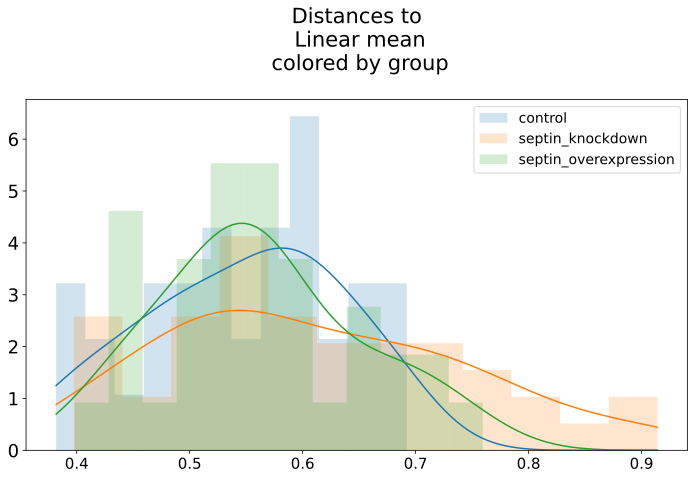

In [324]:
hist_dists_to_means(total_dists_summary, label_color_incr=0)

## 5.5 Distances from Knockdown and Overexpression means to control mean

In [ ]:
knockdown_to_control_dists = {}

knockdown_to_control_dists["Linear"] = [gs.linalg.norm(knockdown_means["Linear"] - control_means["Linear"]).numpy() / n_sampling_points]

knockdown_to_control_dists["SRV"] = [
    SRV_METRIC.dist(knockdown_means["SRV"], control_means["SRV"]).numpy() / n_sampling_points
]

for a, b in zip(AS, BS):
    knockdown_to_control_dists[a, b] =  [
    ELASTIC_METRIC[a, b].dist(knockdown_means[a, b], control_means[a, b]).numpy() / n_sampling_points
]
    
print(knockdown_to_control_dists)

In [ ]:
overexp_to_control_dists = {}

overexp_to_control_dists["Linear"] = [gs.linalg.norm(overexp_means["Linear"] - control_means["Linear"]).numpy() / n_sampling_points]

overexp_to_control_dists["SRV"] = [
    SRV_METRIC.dist(overexp_means["SRV"], control_means["SRV"]).numpy() / n_sampling_points
]

for a, b in zip(AS, BS):
    overexp_to_control_dists[a, b] =  [
    ELASTIC_METRIC[a, b].dist(overexp_means[a, b], control_means[a, b]).numpy() / n_sampling_points
]
    
print(overexp_to_control_dists)

# 7. Clustering each set of data

Now, mostly for my own curiosity, i wanted to cluster the data.

## Description of k means algorithm

From [wikipedia](https://en.wikipedia.org/wiki/K-means_clustering): "that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster... k-means clustering minimizes within-cluster variances (squared Euclidean distances), but not regular Euclidean distances, which would be the more difficult Weber problem: the mean optimizes squared errors, whereas only the geometric median minimizes Euclidean distances. For instance, better Euclidean solutions can be found using k-medians and k-medoids." another useful [site](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

## clusters for control

In [ ]:
# LINEAR
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=3)

#we are forced to use a 2D array (that is why we reshape)
control_dists_linear = np.array(control_dists["Linear"])
Kmean.fit(control_dists_linear.reshape(-1,1))

In [ ]:
Kmean.cluster_centers_

In [ ]:
#Now, for SRV
Kmean = KMeans(n_clusters=3)

#we are forced to use a 2D array (that is why we reshape)
control_dists_linear = np.array(control_dists["SRV"])
Kmean.fit(control_dists_linear.reshape(-1,1))

In [ ]:
Kmean.cluster_centers_

## clusters for knockdown

In [ ]:
# LINEAR
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=3)

#we are forced to use a 2D array (that is why we reshape)
knockdown_dists_linear = np.array(knockdown_dists["Linear"])
Kmean.fit(knockdown_dists_linear.reshape(-1,1))

In [ ]:
Kmean.cluster_centers_

In [ ]:
#SRV
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=3)

#we are forced to use a 2D array (that is why we reshape)
knockdown_dists_linear = np.array(knockdown_dists["SRV"])
Kmean.fit(knockdown_dists_linear.reshape(-1,1))

In [ ]:
Kmean.cluster_centers_

## clusters for overexpression

In [ ]:
# LINEAR
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=3)

#we are forced to use a 2D array (that is why we reshape)
overexp_dists_linear = np.array(overexp_dists["Linear"])
Kmean.fit(overexp_dists_linear.reshape(-1,1))

In [ ]:
Kmean.cluster_centers_

In [ ]:
#SRV
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=3)

#we are forced to use a 2D array (that is why we reshape)
overexp_dists_linear = np.array(overexp_dists["SRV"])
Kmean.fit(overexp_dists_linear.reshape(-1,1))

In [ ]:
Kmean.cluster_centers_

Conclusions of misc. analyses: it does not seem like there are obvious "groups" within each dataset.

# Draft of loading cells and aligning based on cell motion

In [15]:
import importlib
importlib.reload(experimental)


control_centers, control_shapes, control_imgs, control_labels, control_theta_array, control_circle_coords_array, control_lefts_array, control_group_tifs = experimental.load_septin_cells( 'Control',
    n_sampling_points=300)

knockdown_centers, knockdown_shapes, knockdown_imgs, knockdown_labels, knockdown_theta_array, knockdown_circle_coords_array, knockdown_lefts_array, knockdown_group_tifs = experimental.load_septin_cells( 'septin_knockdown',
    n_sampling_points=300)

overexp_centers, overexp_shapes, overexp_imgs, overexp_labels, overexp_theta_array, overexp_circle_coords_array, overexp_lefts_array, overexp_group_tifs = experimental.load_septin_cells( 'septin_overexpression',
    n_sampling_points=300)

Loading Control data
n_sampling_points= 300
(36, 512, 512)
[415.5 118.5]
[415.5 118.5]
[453.5 182.5]
[453.5 182.5]
[ 76.5 365.5]
[ 76.5 365.5]
[229.5  87.5]
[229.5  87.5]
[228.5 371.5]
[228.5 371.5]
[444.5  87.5]
[444.5  87.5]
[ 68.5 407.5]
[ 68.5 407.5]
[238.5 398.5]
[238.5 398.5]
[173.5  84.5]
[173.5  84.5]
[246.5  46.5]
[246.5  46.5]
[339.5 106.5]
[339.5 106.5]
[128.5 441.5]
[128.5 441.5]
[275.5 446.5]
[275.5 446.5]
[ 52.5 239.5]
[ 52.5 239.5]
[423.5 158.5]
[423.5 158.5]
[196.5  97.5]
[196.5  97.5]
[209.5 449.5]
[209.5 449.5]
[422.5 341.5]
[422.5 341.5]
[ 67.5 398.5]
[ 67.5 398.5]
[453.5 312.5]
[453.5 312.5]
[119.5 174.5]
[119.5 174.5]
[210.5  79.5]
[210.5  79.5]
[380.5 223.5]
[380.5 223.5]
[382.5 403.5]
[382.5 403.5]
[264.5  87.5]
[264.5  87.5]
[368.5 123.5]
[368.5 123.5]
[403.5 392.5]
[403.5 392.5]
[123.5 330.5]
[123.5 330.5]
[306.5  65.5]
[306.5  65.5]
[280.5 444.5]
[280.5 444.5]
[ 66.5 159.5]
[ 66.5 159.5]
[355.5 112.5]
[355.5 112.5]
[166.5 443.5]
[166.5 443.5]
[111.5 214.5]
[11

In [ ]:
# cell_centers, cell_shapes, cell_imgs, group_labels, theta_array, circle_coords_array, lefts_array

img_id = 0
one_center = control_centers[img_id]; print(one_center)
one_img = control_imgs[img_id]; print(one_img.shape)
one_shape = control_shapes[img_id]; print(one_shape.shape)
one_circle = control_circle_coords_array[img_id]; print(one_circle)
one_left = control_lefts_array[img_id]; print(one_left)
theta = control_theta_array[img_id]; print(theta)
one_path = control_group_tifs[img_id]; print(one_path)

plt.figure(figsize=(6, 6))
plt.imshow(one_img, cmap="gray")
plt.scatter(one_center[0], one_center[1], color="C0", s=50, label="center")
plt.plot(one_shape[:, 0]+one_center[0], one_shape[:, 1]+one_center[1], linewidth=4, color="C1", label="shape")
plt.scatter(one_left[0], one_left[1], color="C2", s=50, label="left")
plt.scatter(one_circle[0], one_circle[1], color="C3", s=50, alpha = 0.4, label="circle")
plt.title(f"Theta: {theta} \n {one_path}")

plt.legend()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i_ax, shapes_tuple in enumerate(
    zip(["control", "knockdown", "overexpressed"], [control_shapes, knockdown_shapes, overexp_shapes])):
    shape_name, shapes = shapes_tuple
    for i, one_shape in enumerate(shapes):
        axes[i_ax].plot(one_shape[:, 0], one_shape[:, 1], alpha=0.4, color=f"C{i}")
    axes[i_ax].set_title(shape_name)
    axes[i_ax].axis("off")

In [230]:
from scipy.stats import gaussian_kde

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i_ax, shapes_tuple in enumerate(
    zip(["control", "knockdown", "overexpressed"], [control_shapes, knockdown_shapes, overexp_shapes])):
    shape_name, shapes = shapes_tuple
    cells_to_plot = shapes
    points_to_plot = cells_to_plot.reshape(-1, 2)

    # Estimates density with a Gaussian Kernel Density Estimation
    # outputs the value of the probability density function (PDF) at the points
    z = gaussian_kde(points_to_plot.T)(points_to_plot.T)  
    print(z[:10])
    z_norm = z # / z.max() --> we do not normalize it, as to keep the exact value of each of the PDFs
    print(z.max())

    axes[i_ax].scatter(
        points_to_plot[:, 0], points_to_plot[:, 1], 
        alpha=0.2, c=z_norm, s=10, cmap="ocean")
    axes[i_ax].set_title(shape_name, fontsize=14)
    axes[i_ax].axis("off")

plt.savefig("dyn/saved_figs/global_mean_shape.png")

[11.08286365 10.34228     9.84684153 10.21730709 10.88443708 10.81431134
 11.00012027  9.52706302  8.86416559  8.528898  ]
16.80870508656062
[ 9.59849521 12.52129336 14.70754052 15.54541819 15.86819135 16.09598399
 15.98790319 15.69518244 15.05969255 15.35709692]
16.934204891753087
[ 7.13734529  7.48132312  8.99915139  8.97522382 10.23057548 10.28116227
 10.42570837 10.62091288 10.68674539  9.94514333]
15.193401144844817


# Re-computing means

In [ ]:
R1 = Euclidean(dim=1)
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2)
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric
L2_METRIC = CURVES_SPACE.l2_curves_metric

ELASTIC_METRIC = {}
AS = [0.80, 0.90, 0.95, 0.97]
BS = [0.5, 0.5, 0.5, 0.5]
for a, b in zip(AS, BS):
    ELASTIC_METRIC[a, b] = DiscreteCurves(R2, a=a, b=b).elastic_metric
    
    
METRICS = {}
METRICS["Linear"] = L2_METRIC
METRICS["SRV"] = SRV_METRIC

In [ ]:
control_means = {}

control_means["Linear"] = gs.mean(control_shapes, axis=0)
control_means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
#         point_type="matrix", 
        method="default").fit(control_shapes).estimate_
for a, b in zip(AS, BS):
    control_means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
#             point_type="matrix", 
            method="default").fit(control_shapes).estimate_

In [ ]:
fig = plt.figure(figsize=(18, 8))

#plt.figtext(0.5, 1, 'Effect of bias addition', ha='right')

fig. suptitle("Mean Shape of Control Cells", ha='right')

ncols = len(control_means) // 2

for i, (mean_name, mean) in enumerate(control_means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)

# DO NOT RUN. KEEP FOR RECORD

In [ ]:
fig = plt.figure(figsize=(18, 8))

#plt.figtext(0.5, 1, 'Effect of bias addition', ha='right')

fig. suptitle("Mean Shape of Control Cells", ha='right')

ncols = len(control_means) // 2

for i, (mean_name, mean) in enumerate(control_means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)